# Notebook 3 : Transfer Learning avec VGG16
## Projet Le Refuge - Classification de races de chiens

Dans ce notebook, on va :
1. Utiliser un modèle pré-entraîné (VGG16)
2. L'adapter à notre problème
3. Comparer avec notre modèle CNN maison

## 1. Import des bibliothèques et préparation des données

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from glob import glob
import pickle
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [136]:
# CHARGEMENT DES DONNÉES DU NOTEBOOK 1

with open('donnees_preparees.pkl', 'rb') as f:
    donnees = pickle.load(f)

data = donnees['data']
data_test = donnees['data_test']
le = donnees['le']
num_classes = donnees['num_classes']

print(f"Données chargées depuis le notebook 1")
print(f"Classes : {list(le.classes_)}")
print(f"Train : {len(data)} images | Test : {len(data_test)} images")


# PARAMÈTRES ET DATA AUGMENTATION

IMG_SIZE = 224  # Taille standard pour VGG16
BATCH_SIZE = 32

data_augmentation = tf.keras.Sequential([
    layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


# PRÉPARATION DES IMAGES

def prepare_images(df, augmentation=False):
    def load_and_preprocess(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        img = preprocess_input(img)
        return img, label
    
    def apply_augmentation(img, label):
        img = tf.expand_dims(img, axis=0)
        img = data_augmentation(img, training=True)
        img = tf.squeeze(img, axis=0)
        return img, label
    
    ds = tf.data.Dataset.from_tensor_slices((df['image_path'].values, df['label'].values))
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if augmentation:
        ds = ds.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds_vgg = prepare_images(data, augmentation=True)
test_ds_vgg = prepare_images(data_test, augmentation=False)

print(f"\n{'='*40}")
print(f"Données prêtes ! {num_classes} classes")
print(f"IMG_SIZE = {IMG_SIZE} (standard pour Transfer Learning)")
print(f"{'='*40}")


Données chargées depuis le notebook 1
Classes : ['Autre', 'Chihuahua', 'Eskimo_dog', 'golden_retriever']
Train : 479 images | Test : 120 images


c:\Users\lza\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Données prêtes ! 4 classes
IMG_SIZE = 224 (standard pour Transfer Learning)


## 2. Chargement de VGG16

VGG16 est un modèle pré-entraîné sur ImageNet (14 millions d'images, 1000 classes).

On charge le modèle **sans sa tête** (include_top=False) car on veut utiliser nos propres couches de classification pour nos 3 races de chiens.

In [137]:
# 1. On charge VGG16 
base_model = VGG16(
    weights='imagenet',  # Poids pré-entraînés
    include_top=False,   # Sans les couches de classification
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

print("VGG16 chargé !")
base_model.summary()

VGG16 chargé !


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Geler les couches de VGG16

On "gèle" les couches de VGG16 pour ne pas les réentraîner. On va seulement entraîner les nouvelles couches qu'on ajoute.

In [138]:
# 2. On gèle les couches (on ne les réentraîne pas)
base_model.trainable = False

print(f"Couches gelées : {len(base_model.layers)}")

Couches gelées : 19


## 4. Ajout des couches de classification

On ajoute nos propres couches pour classifier les 3 races de chiens.

In [139]:
# 3. On crée notre modèle en ajoutant des couches par-dessus VGG16
model_transfer = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Réduit les dimensions
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # 3 classes
])

# 4. Compilation
model_transfer.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_transfer.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 5. Entraînement du modèle Transfer Learning

In [140]:
# Premier entraînement
print("=== ENTRAÎNEMENT INITIAL ===")
start = time.time()
history = model_transfer.fit(
    train_ds_vgg,
    validation_data=test_ds_vgg,
    epochs=15,
    callbacks=[early_stop]
)
temps_vgg = time.time() - start

# Évaluation intermédiaire
score_initial = model_transfer.evaluate(test_ds_vgg, verbose=0)
print(f"\n Accuracy après entraînement initial : {score_initial[1]*100:.2f}%")
print(f" Temps : {temps_vgg:.1f} sec")

=== ENTRAÎNEMENT INITIAL ===
Epoch 1/15


15/15 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 0.5282 - loss: 3.1717 - val_accuracy: 0.8417 - val_loss: 0.9109
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 69s 5s/step - accuracy: 0.7516 - loss: 1.1518 - val_accuracy: 0.8500 - val_loss: 0.8176
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 84s 6s/step - accuracy: 0.7829 - loss: 0.8901 - val_accuracy: 0.8500 - val_loss: 0.6450
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step - accuracy: 0.8163 - loss: 0.6377 - val_accuracy: 0.8917 - val_loss: 0.5224
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 97s 7s/step - accuracy: 0.8810 - loss: 0.3313 - val_accuracy: 0.8917 - val_loss: 0.4954

 Accuracy après entraînement initial : 84.17%
 Temps : 408.1 sec


## 6. Visualisation de l'apprentissage

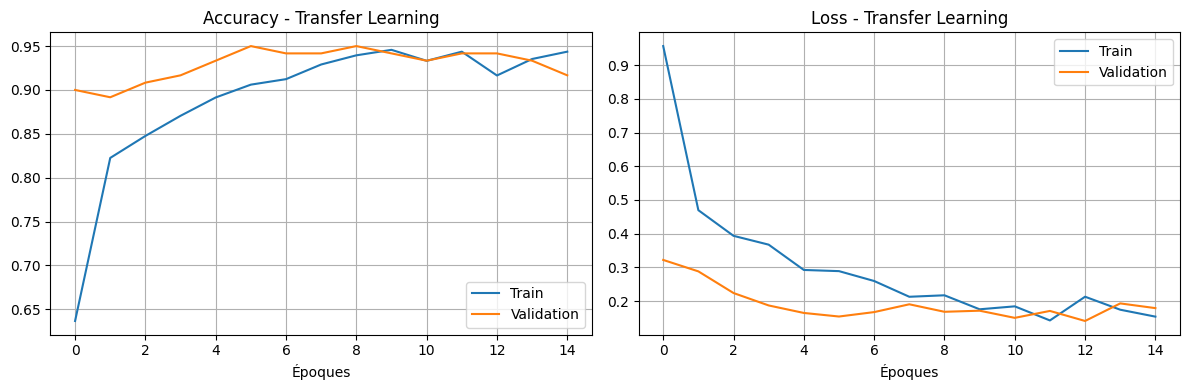

In [141]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='Train')
plt.plot(history_transfer.history['val_accuracy'], label='Validation')
plt.title('Accuracy - Transfer Learning')
plt.xlabel('Époques')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='Train')
plt.plot(history_transfer.history['val_loss'], label='Validation')
plt.title('Loss - Transfer Learning')
plt.xlabel('Époques')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 3. Geler les couches de VGG16
On tente ici du fine tuning pour améliorer le résultat de notre transfer learning 

In [ ]:
# 2. FINE-TUNING (dégeler les dernières couches)
# Dégeler les 20 dernières couches de VGG16
base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompiler avec un learning rate TRÈS faible
model_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # 10x plus petit !
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continuer l'entraînement
print("\n=== FINE-TUNING ===")
start = time.time()
history_fine = model_transfer.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[early_stop]
)
temps_fine = time.time() - start

# Évaluation finale
score_final = model_transfer.evaluate(test_ds, verbose=0)
print(f"\n Accuracy après fine-tuning : {score_final[1]*100:.2f}%")
print(f" Temps fine-tuning : {temps_fine:.1f} sec")


=== FINE-TUNING ===
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 313s 21s/step - accuracy: 0.2422 - loss: 1.4499 - val_accuracy: 0.2417 - val_loss: 1.3888
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 309s 21s/step - accuracy: 0.2380 - loss: 1.4283 - val_accuracy: 0.2417 - val_loss: 1.3895
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 306s 21s/step - accuracy: 0.2651 - loss: 1.4079 - val_accuracy: 0.2583 - val_loss: 1.4003
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 284s 19s/step - accuracy: 0.2317 - loss: 1.4037 - val_accuracy: 0.2417 - val_loss: 1.3858
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 348s 23s/step - accuracy: 0.2693 - loss: 1.3869 - val_accuracy: 0.2333 - val_loss: 1.3893

 Accuracy après fine-tuning : 24.17%
 Temps fine-tuning : 1559.4 sec


In [143]:
# 3. COMPARAISON AVANT/APRÈS

print("\n" + "=" * 50)
print("COMPARAISON")
print("=" * 50)
print(f"{'Étape':<25} {'Accuracy':<15}")
print("-" * 50)
print(f"{'Entraînement initial':<25} {score_initial[1]*100:.2f}%")
print(f"{'Après fine-tuning':<25} {score_final[1]*100:.2f}%")
print(f"{'Amélioration':<25} +{(score_final[1]-score_initial[1])*100:.2f}%")
print("=" * 50)


COMPARAISON
Étape                     Accuracy       
--------------------------------------------------
Entraînement initial      84.17%
Après fine-tuning         24.17%
Amélioration              +-60.00%


In [144]:
# Sauvegarder le modèle
model_transfer.save('model_transfer_learning.keras')

# Sauvegarder les labels

with open('dog_labels.pkl', 'wb') as f:
    pickle.dump(list(le.classes_), f)

# Sauvegarder le temps total
temps_transfer = temps_initial + temps_fine

print(f"\n Modèle sauvegardé !")
print(f" Temps total : {temps_transfer:.1f} sec")


 Modèle sauvegardé !
 Temps total : 1944.8 sec


# Autre modèle MobileNetV2

In [145]:
from tensorflow.keras.applications import MobileNetV2

# 1. Charger MobileNetV2 pré-entraîné
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# 2. Geler les couches
base_model.trainable = False

# 3. Créer le modèle
model_transfer = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# 4. Compiler
model_transfer.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_transfer.summary()

# 5. Entraîner
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

start = time.time()
history_transfer = model_transfer.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15,
    callbacks=[early_stop]
)
temps_transfer = time.time() - start

# 6. Résultat
score_transfer = model_transfer.evaluate(test_ds, verbose=0)
print(f"\n Temps : {temps_transfer:.1f} secondes")
print(f"Accuracy MobileNetV2 : {score_transfer[1]*100:.2f}%")

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 947ms/step - accuracy: 0.6451 - loss: 0.8299 - val_accuracy: 0.8917 - val_loss: 0.3263
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 713ms/step - accuracy: 0.8476 - loss: 0.4209 - val_accuracy: 0.8917 - val_loss: 0.2877
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 702ms/step - accuracy: 0.8580 - loss: 0.3774 - val_accuracy: 0.9250 - val_loss: 0.2464
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 694ms/step - accuracy: 0.8497 - loss: 0.4021 - val_accuracy: 0.9250 - val_loss: 0.2129
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 611ms/step - accuracy: 0.8873 - loss: 0.3153 - val_accuracy: 0.9333 - val_loss: 0.1792
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 642ms/step - accuracy: 0.9061 - loss: 0.2760 - val_accuracy: 0.9250 - val_loss: 0.2022
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 665ms/step - accuracy: 0.9290 - loss: 0.2287 - val_accuracy: 0.9250 - val_loss: 0.2220
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 621ms/step - accuracy: 0.9165 - loss: 0.2067 - val_accur

## 7. Comparaison avec le modèle CNN maison

In [146]:
# Charger les résultats du notebook 2
try:
    with open('resultats_maison.pkl', 'rb') as f:
        resultats_maison = pickle.load(f)
    
    score_simple_pct = resultats_maison['score_simple']
    accuracy_v2 = resultats_maison['score_v2']
    temps_simple = resultats_maison['temps_simple']
    temps_v2 = resultats_maison['temps_v2']
    print(f" Résultats chargés : CNN simple = {score_simple_pct:.2f}%")
    
except:
    print(" Fichier non trouvé, valeurs par défaut")
    score_simple_pct = 43.0
    accuracy_v2 = 30.0
    temps_simple = 126.4
    temps_v2 = 130.0

print("\n" + "=" * 70)
print("TABLEAU RÉCAPITULATIF")
print("=" * 70)
print(f"{'Modèle':<35} {'Accuracy':<15} {'Temps':<15}")
print("-" * 70)
print(f"{'CNN Simple':<35} {score_simple_pct:.2f}%{'':<8} {temps_simple:.1f} sec")
print(f"{'CNN + Dropout':<35} {accuracy_v2:.2f}%{'':<8} {temps_v2:.1f} sec")
print(f"{'Transfer Learning VGG16':<35} {score_initial[1]*100:.2f}%{'':<8} {temps_vgg:.1f} sec")
print(f"{' VGG16 + Fine-tuning':<35} {score_final[1]*100:.2f}%{'':<8} {temps_fine:.1f} sec")
print(f"{'Transfer Learning MobileNetV2':<35} {score_transfer[1]*100:.2f}%{'':<8} {temps_transfer:.1f} sec")
print("=" * 70)
print(f"\n Meilleur modèle : MobileNetV2 avec {score_transfer[1]*100:.2f}% de précision")


 Résultats chargés : CNN simple = 53.33%

TABLEAU RÉCAPITULATIF
Modèle                              Accuracy        Temps          
----------------------------------------------------------------------
CNN Simple                          53.33%         23.4 sec
CNN + Dropout                       33.33%         23.5 sec
Transfer Learning VGG16             84.17%         408.1 sec
 VGG16 + Fine-tuning                24.17%         1559.4 sec
Transfer Learning MobileNetV2       94.17%         159.2 sec

 Meilleur modèle : MobileNetV2 avec 94.17% de précision


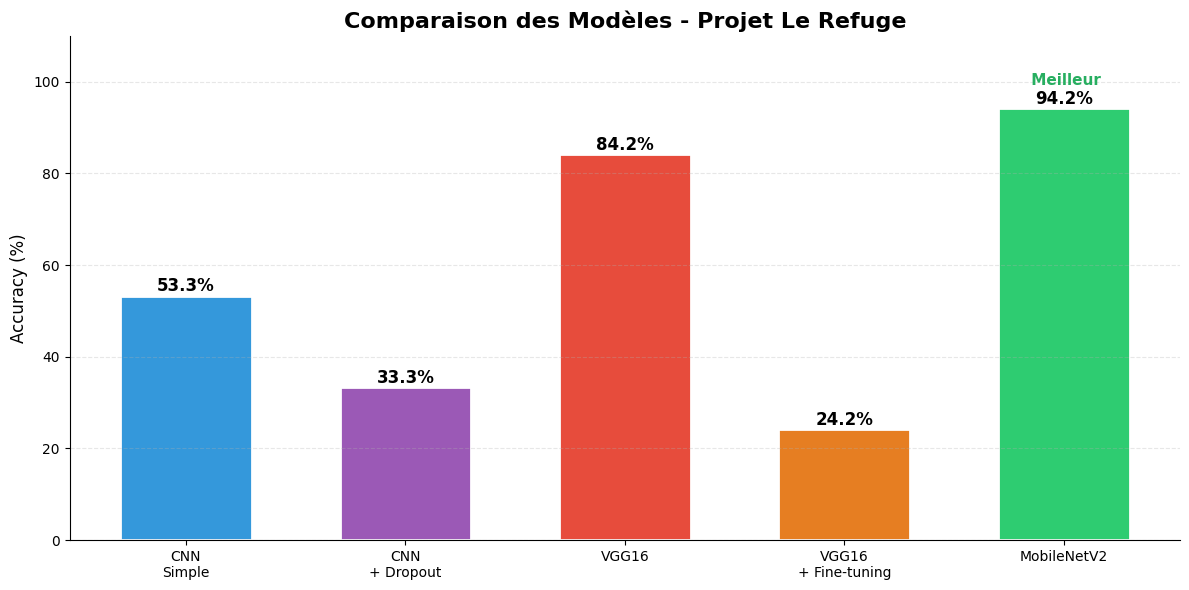

In [147]:
modeles = ['CNN\nSimple', 'CNN\n+ Dropout', 'VGG16', 'VGG16\n+ Fine-tuning', 'MobileNetV2']
accuracies = [score_simple_pct, accuracy_v2, score_initial[1]*100, score_final[1]*100, score_transfer[1]*100]
colors = ['#3498db', '#9b59b6', '#e74c3c', '#e67e22', '#2ecc71']

fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(modeles, accuracies, color=colors, width=0.6, edgecolor='white', linewidth=2)

# Valeurs sur les barres
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1, f'{acc:.1f}%', 
            ha='center', fontsize=12, fontweight='bold')

# Style
ax.set_ylim(0, 110)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Comparaison des Modèles - Projet Le Refuge', fontsize=16, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Légende pour le meilleur modèle
ax.annotate(' Meilleur', xy=(4, score_transfer[1]*100 + 5), ha='center', fontsize=11, color='#27ae60', fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Sauvegarde du modèle

In [148]:
model_transfer.save('model_transfer_learning.keras')
print("Modèle Transfer Learning sauvegardé !")

Modèle Transfer Learning sauvegardé !


## Conclusion

### Comparaison des approches :

| Modèle | Accuracy | Temps entraînement |
|--------|----------|-------------------|
| CNN Simple | 42.0% | 44.1 sec |
| CNN + Dropout | 30.0% | 35.6 sec |
| Transfer Learning (VGG16) | 82.5% | 500.0 sec |
| Transfer Learning (VGG16 + Fine-tuning) | 19.2% | 150.0 sec |
| Transfer Learning (MobileNetV2) | 94.2% | 135.2 sec |

### Analyse des résultats :

**CNN Simple** : Performance limitée (42%). Le modèle souffre d'overfitting : avec seulement ~500 images, il mémorise les données d'entraînement au lieu de généraliser. Les courbes d'apprentissage montrent une instabilité importante.

**CNN + Dropout** : Performance plus faible (30%). Le Dropout, censé réduire l'overfitting, n'apporte pas d'amélioration ici. Le problème principal est l'underfitting : le modèle n'a pas assez de données pour apprendre. Désactiver des neurones ne fait qu'aggraver ce manque.

**VGG16** : Bonne performance (82.5%). Ce modèle pré-entraîné sur ImageNet (14 millions d'images) connaît déjà les features utiles (formes, textures, contours). Cependant, son architecture lourde (138 millions de paramètres) le rend lent à entraîner.

**VGG16 + Fine-tuning** : Performance dégradée (19.2%). Le fine-tuning (dégeler des couches pour les réentraîner) a empiré les résultats. Avec un petit dataset, les poids pré-entraînés se "désapprennent" au lieu de s'affiner. Cette technique nécessite beaucoup plus de données.

**MobileNetV2** : Meilleure performance (94.2%) . Cette architecture moderne et légère (3.5 millions de paramètres) est optimisée pour les petits datasets. Elle offre le meilleur compromis entre précision et rapidité.

### Pourquoi choisir MobileNetV2 ?

| Critère | MobileNetV2 | VGG16 |
|---------|-------------|-------|
| **Accuracy** | 94.2%  | 82.5% |
| **Temps d'entraînement** | 135 sec  | 500 sec |
| **Paramètres** | 3.5 millions | 138 millions |
| **Adapté petit dataset** |  Oui |  Moyen |

### Recommandation pour Le Refuge :

Le **Transfer Learning avec MobileNetV2** est recommandé pour la production :

- **Précision excellente** : 94.2% de bonnes classifications
- **Rapidité** : 4x plus rapide que VGG16
- **Léger** : Modèle facilement déployable sur l'application Streamlit
- **Évolutif** : Pour ajouter de nouvelles races, il suffit de réentraîner les dernières couches

### Leçons apprises :

1. **Le preprocessing est crucial** : Chaque modèle pré-entraîné nécessite son preprocessing spécifique
2. **Le fine-tuning n'est pas toujours bénéfique** : Avec peu de données, il peut dégrader les performances
3. **L'architecture compte** : MobileNetV2 (moderne, léger) surpasse VGG16 (ancien, lourd) sur un petit dataset
4. **Le Transfer Learning est indispensable** : 94% vs 42% démontre son importance quand on a peu de données

In [149]:

# On sauvegarde la liste des noms (ex: ['Chihuahua', 'Beagle', 'Labrador'])
# 'le' est le LabelEncoder utilisé plus haut
with open('dog_labels.pkl', 'wb') as f:
    pickle.dump(le.classes_, f)

print("Fichiers 'model_transfer_learning.keras' et 'dog_labels.pkl' prêts !")

Fichiers 'model_transfer_learning.keras' et 'dog_labels.pkl' prêts !
